In [57]:
import os
import os.path as op
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from glob import glob
import logging

# Ignore warnings
# import warnings

# warnings.filterwarnings("ignore")

plt.ion()  # interactive mode


# install pytorch correctly
# https://discuss.pytorch.org/t/torch-cuda-is-not-available/74845/11
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
logging.basicConfig(level=logging.INFO,)
# install cuda driver ubuntu
# https://ubuntu.com/server/docs/nvidia-drivers-installation

cuda


In [29]:
# https://pytorch.org/docs/stable/cuda.html
# torch.cuda.is_initialized()

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"Current cuda device: {torch.cuda.get_device_name(current_device)}")

Current cuda device: NVIDIA RTX A2000


In [30]:
# script for segmentation
# https://github.com/mateuszbuda/brain-segmentation-pytorch

['/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-3/run-01/petra_.nii.gz', '/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-3/run-02/petra_.nii.gz', '/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-4/run-01/petra_.nii.gz', '/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-4/run-02/petra_.nii.gz', '/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-1/run-01/petra_.nii.gz', '/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-2/run-01/petra_.nii.gz', '/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-2/run-02/petra_.nii.gz']
Img Size: torch.Size([224, 288, 288])
Label Size: torch.Size([224, 2

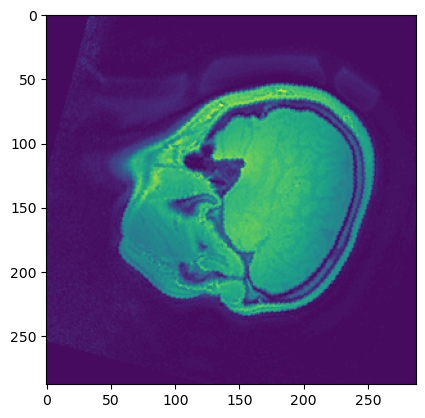

In [61]:
# help in loading images
# https://discuss.pytorch.org/t/how-to-load-all-the-nii-from-the-directory-without-augmentation-using-pytorch-dataloader/60938/3
root_dir = "/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train"
seg_dir = "/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train"


class DataloaderImg(Dataset):
    def __init__(self, root_dir, transforms):
        self.root_dir = root_dir
        self.transforms = transforms
        self.subject_pattern = op.join(self.root_dir, "sub-*", "electrode_extraction", "ses-*", "run-*", )
        self.files = glob(op.join(self.subject_pattern, "petra_.nii.gz")) 
        self.labels = glob(op.join(self.subject_pattern, "cylinder_plus_plug_ROI_FN.nii.gz")) # TODO: change file name
        print(self.files)

    def __len__(self):
        # TODO: change so that it returns the actual number of files not number of subjects
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        label_name = self.labels[idx]
        img = nib.load(img_name)
        # change to numpy
        img = torch.from_numpy(np.asarray(img.dataobj))
        # change to PIL
        #       img = Image.fromarray(img.astype('uint8'), 'RGB')
        print(f"Img Size: {img.size()}")

        label = nib.load(label_name)
        # change to numpy
        label = torch.from_numpy(np.asarray(label.dataobj))
        # change to PIL
        #       label = Image.fromarray(label.astype('uint8'), 'RGB')

        print(f"Label Size: {label.size()}")

        if self.transforms:
            img = self.transforms(img)
            label = self.transforms(label)
            return img, label
        else:
            return img, label


# full_dataset = Dataloder_img('C:/Users/Ali ktk/.spyder-py3/dataloader/data/train/1', 'C:/Users/Ali ktk/.spyder-py3/dataloader/data/train/1/ADNI_136_S_0300_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080529142830882_S50401_I107759.nii' ,tfms.Compose([tfms.RandomRotation(180).tfms.ToTensor()]))
full_dataset = DataloaderImg(
    "/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train",
    transforms.Compose([transforms.RandomRotation(180)]),
)


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

bs = 4
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=bs)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=bs)

test_img, test_lb = next(iter(full_dataset))
print(test_img[0].shape)
plt.imshow(test_img[60]);

In [7]:
class BrainSegmentationDataset(Dataset):
    """Brain MRI dataset for FLAIR abnormality segmentation"""

    in_channels = 3
    out_channels = 1

    def __init__(
        self,
        images_dir,
        transform=None,
        image_size=256,
        subset="train",
        random_sampling=True,
        validation_cases=40,
        seed=42,  # ???
    ):
        assert subset in ["all", "train", "validation"]

        # read images
        volumes = {}
        masks = {}
        print("reading {} images...".format(subset))
        for dirpath, dirnames, filenames in os.walk(images_dir):
            image_slices = []
            mask_slices = []
            for filename in sorted(
                filter(lambda f: ".tif" in f, filenames),
                key=lambda x: int(x.split(".")[-2].split("_")[4]),
            ):
                filepath = os.path.join(dirpath, filename)
                if "mask" in filename:
                    mask_slices.append(imread(filepath, as_gray=True))
                else:
                    image_slices.append(imread(filepath))
            if len(image_slices) > 0:
                patient_id = dirpath.split("/")[-1]
                volumes[patient_id] = np.array(image_slices[1:-1])
                masks[patient_id] = np.array(mask_slices[1:-1])

        self.patients = sorted(volumes)

        # select cases to subset
        if not subset == "all":
            random.seed(seed)
            validation_patients = random.sample(self.patients, k=validation_cases)
            if subset == "validation":
                self.patients = validation_patients
            else:
                self.patients = sorted(
                    list(set(self.patients).difference(validation_patients))
                )

        print("preprocessing {} volumes...".format(subset))
        # create list of tuples (volume, mask)
        self.volumes = [(volumes[k], masks[k]) for k in self.patients]

        print("cropping {} volumes...".format(subset))
        # crop to smallest enclosing volume
        self.volumes = [crop_sample(v) for v in self.volumes]

        print("padding {} volumes...".format(subset))
        # pad to square
        self.volumes = [pad_sample(v) for v in self.volumes]

        print("resizing {} volumes...".format(subset))
        # resize
        self.volumes = [resize_sample(v, size=image_size) for v in self.volumes]

        print("normalizing {} volumes...".format(subset))
        # normalize channel-wise
        self.volumes = [(normalize_volume(v), m) for v, m in self.volumes]

        # probabilities for sampling slices based on masks
        self.slice_weights = [m.sum(axis=-1).sum(axis=-1) for v, m in self.volumes]
        self.slice_weights = [
            (s + (s.sum() * 0.1 / len(s))) / (s.sum() * 1.1) for s in self.slice_weights
        ]

        # add channel dimension to masks
        self.volumes = [(v, m[..., np.newaxis]) for (v, m) in self.volumes]

        print("done creating {} dataset".format(subset))

        # create global index for patient and slice (idx -> (p_idx, s_idx))
        num_slices = [v.shape[0] for v, m in self.volumes]
        self.patient_slice_index = list(
            zip(
                sum([[i] * num_slices[i] for i in range(len(num_slices))], []),
                sum([list(range(x)) for x in num_slices], []),
            )
        )

        self.random_sampling = random_sampling

        self.transform = transform

    def __len__(self):
        return len(self.patient_slice_index)

    def __getitem__(self, idx):
        patient = self.patient_slice_index[idx][0]
        slice_n = self.patient_slice_index[idx][1]

        if self.random_sampling:
            patient = np.random.randint(len(self.volumes))
            slice_n = np.random.choice(
                range(self.volumes[patient][0].shape[0]), p=self.slice_weights[patient]
            )

        v, m = self.volumes[patient]
        image = v[slice_n]
        mask = m[slice_n]

        if self.transform is not None:
            image, mask = self.transform((image, mask))

        # fix dimensions (C, H, W)
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(mask.astype(np.float32))

        # return tensors
        return image_tensor, mask_tensor